In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

In [127]:
data = pd.read_csv("data/datahw2.csv").drop("Id",axis=1)

In [128]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## preprocessing

In [129]:
# data.info()

решил убрать признаки у которых слишком мало не nan

In [130]:
cat = ["MiscFeature", "Fence", "PoolQC","FireplaceQu","MasVnrType","MasVnrType","Alley"]
data = data.drop(cat,axis=1)
data = data.dropna()
print(data.shape)

(1094, 74)


In [131]:
target = data["SalePrice"]
data = data.drop("SalePrice",axis=1)

Чтобы графики были адекватными

In [132]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

target = ss.fit_transform(target.values.reshape(-1,1))
target = target.ravel()

In [133]:
from sklearn.preprocessing import LabelEncoder

class autoLabelEncoder:
    def __init__(self) -> None:
        self.cat_encoders:dict = {}

    def fit(self, data:pd.DataFrame, categories:list[str]) -> None:
        for feat in categories:
            enc = LabelEncoder()
            self.cat_encoders[feat] = enc.fit(data.loc[data[feat].notna(), feat])

    def transform(self, data:pd.DataFrame, categories:list[str]) -> pd.DataFrame:
        for feat in categories:
            if(feat in data.columns):
                enc = self.cat_encoders[feat]
                data.loc[data[feat].notna(), feat] = (enc.transform(data.loc[data[feat].notna(), feat]))
                data[feat] = data[feat].astype(int)
        return data
    
    def get_encoder(self, category) -> LabelEncoder:
        return self.cat_encoders[category]


In [134]:
cat = data.select_dtypes(include='object')
le = autoLabelEncoder()
le.fit(data,cat)
data = le.transform(data, cat)

In [135]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

## task 1

### a

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

for depth in range(1,15):
    rr = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=2, bootstrap=False)
    print(-np.mean(cross_validate(rr,X_train,y_train,cv=5,scoring="neg_mean_squared_error")["test_score"]), f"depth {depth}")

0.5275140331615946 depth 1
0.38491555156227814 depth 2
0.2900847391741033 depth 3
0.2610183212763317 depth 4
0.2762645226065083 depth 5
0.270503341897025 depth 6
0.2646332000731313 depth 7
0.2378651755304034 depth 8
0.27217985669708333 depth 9
0.2392010469487719 depth 10
0.2864703318932228 depth 11
0.25338212070842203 depth 12
0.24041986849868321 depth 13
0.2473718917535784 depth 14


6 наилуч (варируется)

### b

In [138]:
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor(n_estimators=1, max_depth=6, bootstrap=False)
rr.fit(X_train,y_train)
pred = rr.predict(X_test)
err = mean_squared_error(pred,y_test)


<Axes: >

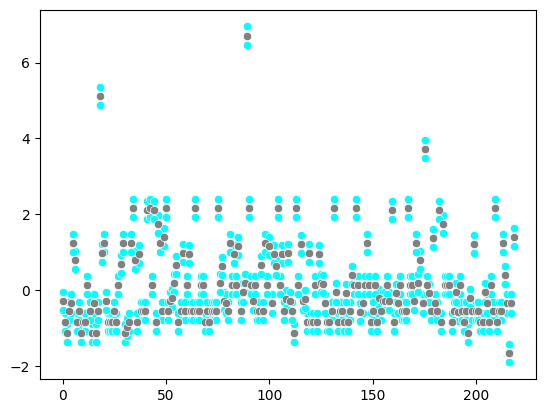

In [139]:
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred+err, color='cyan')
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred-err,  color='cyan')
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred, color="gray")

### c

In [140]:
showing = []
for i in range(1,100,5):
    rr = RandomForestRegressor(n_estimators=i, max_depth=6, bootstrap=False)
    rr.fit(X_train,y_train)
    showing.append(mean_squared_error(rr.predict(X_test),y_test))

<Axes: >

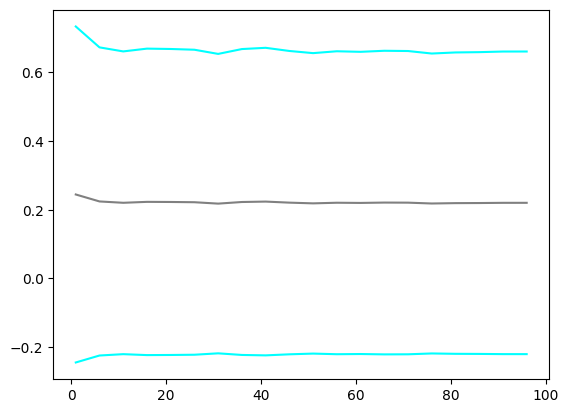

In [141]:
sns.lineplot(x=np.arange(1,100,5),y = showing, color='gray')
sns.lineplot(x=np.arange(1,100,5),y = [2*i + i for i in showing], color='cyan')
sns.lineplot(x=np.arange(1,100,5),y = [-2*i + i for i in showing], color='cyan')

### d

In [142]:
rr = RandomForestRegressor(n_estimators=1, max_depth=9, bootstrap=False)
rr.fit(X_train,y_train)
pred = rr.predict(X_test)

Интервалы ошибок можно построить в данном случае т.к у нас есть тестовые таргеты. Либо можно использовать сред. ошибку на тесте.

<Axes: >

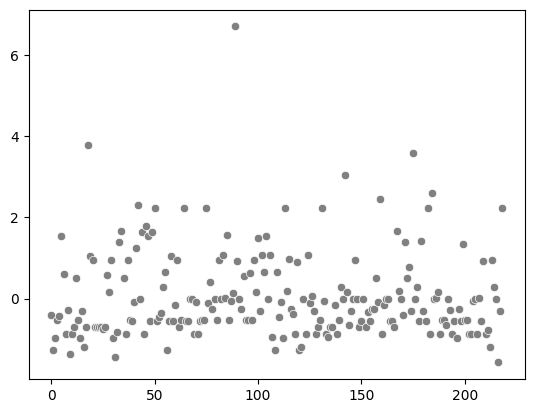

In [143]:
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred, color='gray')

## task 2

In [144]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

### a

In [145]:
par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
tree = DecisionTreeRegressor()
rcv = RandomizedSearchCV(tree, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
tree = DecisionTreeRegressor(**rcv.best_params_)
for i in range(20):
    tree.fit(X_train,y_train)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="r2")
    out_err.append(np.mean(cv["test_score"]))
    out_var.append(np.var(cv["test_score"]))

0.7561741563636123  сред r2 набора моделей содержащих одно дерево
0.0056112795811832  сред дисперсия


<Axes: >

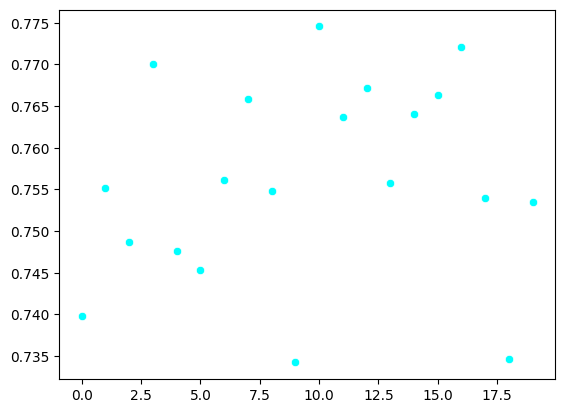

In [146]:
print(np.mean(out_err) , f" сред r2 набора моделей содержащих одно дерево")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

Видим разброс средних ошибок на кроссвалидации для набора одиночных деревьев. (Каждая точка среднее значение r2 на cv для одного дерева).\
По большей степни график показыает как значение r2 варируется от random_state, если фиксируем то идельная линия (все деревья одинаковые).

### b

In [147]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor()

for depth in range(5,15):
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=2)
    br = BaggingRegressor(tree, n_estimators=20, max_samples=1., max_features=1., random_state=8)
    cv = cross_validate(br,X_train,y_train,cv=10,scoring="r2")
    print(f"depth {depth}")
    print(np.mean(cv["test_score"]), "mean")
    print(np.var(cv["test_score"]), "var")

depth 5
0.8164783486461078 mean
0.0035876550602769045 var
depth 6
0.8312808693437225 mean
0.003077634442275759 var
depth 7
0.8391963252650958 mean
0.0032746831085424728 var
depth 8
0.8396468933582149 mean
0.0036240263729197066 var
depth 9
0.8445575335447499 mean
0.003187853141874665 var
depth 10
0.8445809220927707 mean
0.002915723268232907 var
depth 11
0.8442885382440268 mean
0.003328469951127623 var
depth 12
0.8440253886892984 mean
0.003255249400192668 var
depth 13
0.8428822623605192 mean
0.0034699739094700907 var
depth 14
0.8447259928788476 mean
0.0035125664384299746 var


Дисперсия уменшились (сильно зависит от рандом состояния), r2 увеличивается в следствие беггинга. При увеличении глубины точность увеличивается затем имеем переобучение.

### d

In [148]:
from mlxtend.evaluate import bias_variance_decomp

meta = []
tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=2)
for i in range(10,200,20):
    model = BaggingRegressor(tree, n_estimators=i, max_samples=0.5, max_features=0.8, random_state=1)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

Довольно долгое обучение до 500 не получилось. 

In [149]:
def draw_bv(meta):
    sns.lineplot(x=[i[0] for i in meta], y=[i[1] for i in meta],label="bias")
    sns.lineplot(x=[i[0] for i in meta], y=[i[2] for i in meta],label="var")
    plt.plot()

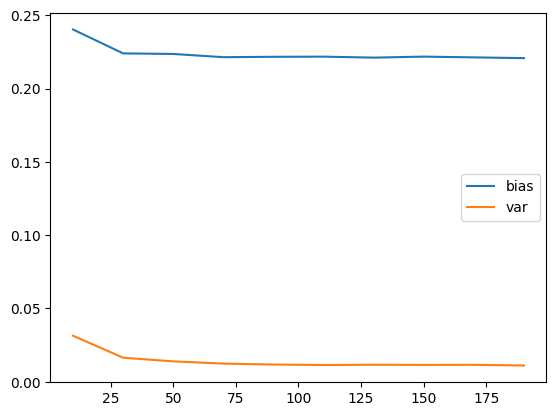

In [150]:
draw_bv(meta)

## task 3

### Шаги из 2

In [151]:
from sklearn.ensemble import RandomForestRegressor

par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
rf = RandomForestRegressor(n_estimators=1)
rcv = RandomizedSearchCV(rf, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
for i in range(20):
    tree = RandomForestRegressor(n_estimators=1,**rcv.best_params_)
    tree.fit(X_train,y_train)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="r2")
    out_err.append(np.mean(cv["test_score"]))
    out_var.append(np.var(cv["test_score"]))

0.6754690958619748  сред r2 набора моделей содержащих одно дерево
0.014433136176044987  сред дисперсия


<Axes: >

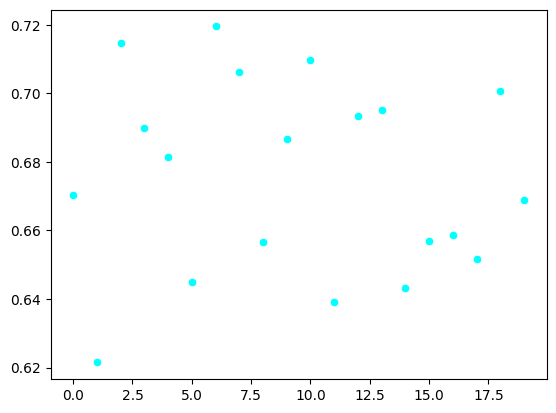

In [152]:
print(np.mean(out_err) , f" сред r2 набора моделей содержащих одно дерево")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

Видим ошибку которая в дальнейшем (когда используем ансамбли) окажется значительной.

In [153]:
for depth in range(5,15):
    tree = RandomForestRegressor(n_estimators=20,max_depth=depth, min_samples_leaf=2,random_state=2332)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="r2")
    print(f"depth {depth}")
    print(np.mean(cv["test_score"]), "mean")
    print(np.var(cv["test_score"]), "var")

depth 5
0.7972024766117323 mean
0.00768476952054091 var
depth 6
0.8122221787534404 mean
0.007274643497295688 var
depth 7
0.8249740447130336 mean
0.005793209104724785 var
depth 8
0.8269148655102858 mean
0.005853363222417944 var
depth 9
0.8286576404765593 mean
0.005677622057937909 var
depth 10
0.8282853979547887 mean
0.006699107987815689 var
depth 11
0.8307483545983114 mean
0.0054088273338726124 var
depth 12
0.8296652149079936 mean
0.00616032996287 var
depth 13
0.8304027481385887 mean
0.006187464150275194 var
depth 14
0.8271215568133983 mean
0.006592026110640832 var


Ожидаемо точность выше, дисперсия ниже.

In [154]:
meta = []
for i in range(10,200,20):
    model = RandomForestRegressor(n_estimators=i,max_depth=9,min_samples_leaf=2)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

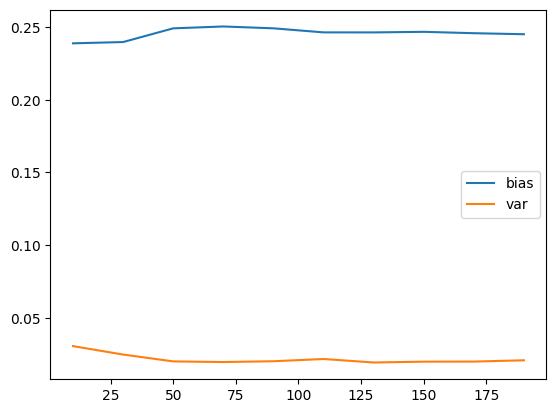

In [155]:
draw_bv(meta)

### a

In [156]:
impot = []
tree = RandomForestRegressor(n_estimators=20, max_depth=6, min_samples_leaf=2, random_state=1)
tree.fit(X_train,y_train)
for num,feat in zip(tree.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(tree.predict(X_test), y_test), 'all features')

[(0.6408818393971605, 'OverallQual'), (0.08479899901434178, 'GrLivArea'), (0.04183636822228897, '2ndFlrSF'), (0.0286435571980467, '1stFlrSF'), (0.025971989108144983, 'TotalBsmtSF'), (0.014374995477118922, 'LotArea'), (0.012850090440161605, 'FullBath'), (0.012608477635847704, 'BsmtFinSF1'), (0.010081928264411372, 'YearBuilt'), (0.00926917852639231, 'TotRmsAbvGrd'), (0.009134710158556816, 'GarageYrBlt'), (0.00884268820933176, 'ExterQual'), (0.008247327252977497, 'GarageCars'), (0.007361718508145214, 'GarageArea'), (0.006993735952488124, 'LotFrontage'), (0.006720750547555835, 'GarageType'), (0.006652029028653077, 'MoSold'), (0.0061612598130936745, 'Neighborhood'), (0.005621344925248817, 'OpenPorchSF'), (0.005262893907006251, 'YearRemodAdd'), (0.005143041605943235, 'KitchenQual'), (0.004847550641582469, 'OverallCond'), (0.0044725289810409056, 'BsmtQual'), (0.0040536733990292955, 'GarageFinish'), (0.004002462133811522, 'BsmtUnfSF'), (0.0030798620168074153, 'WoodDeckSF'), (0.0025029670711285

In [157]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1299,20,3,75.0,7500,1,3,3,0,4,0,...,0,0,0,0,0,0,5,2010,8,4
575,50,3,80.0,8480,1,3,3,0,4,0,...,0,102,0,0,0,0,10,2008,0,0
1376,30,3,52.0,6292,1,3,0,0,4,0,...,141,0,0,0,0,0,4,2008,8,4
892,20,3,70.0,8414,1,3,3,0,4,0,...,0,0,0,0,0,0,2,2006,8,4
1068,160,4,42.0,3964,1,3,3,0,4,0,...,20,0,0,0,0,0,6,2006,8,4


### b

In [158]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    tree.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(tree.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'GrLivArea', '2ndFlrSF']
0.1596386865729338 on 3 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF']
0.16365881662678505 on 4 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF']
0.15799967133755563 on 5 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea']
0.15699545775119625 on 6 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea', 'FullBath']
0.15131788494440018 on 7 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea', 'FullBath', 'BsmtFinSF1']
0.13001311558388653 on 8 features


Результат лучше чем для всех, видимо очень сильно влияет какие признаки попадут в дерево т.к глубина не сильно большая

### c

*Для сравнения oob и cv попробуем определить оптимальную глубину дерева используя эти оценки

In [159]:
print("cv mse".ljust(38),"| oob".ljust(38), "| depth")
for i in range(5,25):
    model = RandomForestRegressor(n_estimators=50,max_depth=i,min_samples_leaf=2,oob_score=True, random_state=1)
    model.fit(X_train,y_train)
    print(f"{-np.mean(cross_validate(model,X_train,y_train,cv=5,scoring="neg_mean_squared_error")["test_score"])}".ljust(38), f"| {model.oob_score_}".ljust(38), f"| {i}")

cv mse                                 | oob                                  | depth
0.19026686733403864                    | 0.7871680735906081                   | 5
0.1822062436214868                     | 0.7974067558933028                   | 6
0.1740829945480808                     | 0.805673032165235                    | 7
0.17239988053065317                    | 0.8080785348899487                   | 8
0.16949823200903913                    | 0.8128906382011718                   | 9
0.16664352828634246                    | 0.8150471358620756                   | 10
0.167402571956672                      | 0.8115106268771358                   | 11
0.1700729617586964                     | 0.8114241613186395                   | 12
0.16502382647726166                    | 0.8158498170975369                   | 13
0.17214135855418358                    | 0.8092557633951448                   | 14
0.1648697040537474                     | 0.8149157785539392                   | 15
0.1663

Мы видим что однозначного пересечения нет (oob подрузамевает r2 метрику которую мы максимизируем).Но видим, что значения глубины не сильно отличаются. Механизмы довольно похожи, единственное oob получается почти бесплатно в сравнении с перекрестным вычислением cv.
В реальности стоит оценить обе этих метрики, чтобы обоснованнее оценить генерализацию модели.

Посмотрим что у нас на тесте

In [160]:
model = RandomForestRegressor(n_estimators=50,max_depth=15,min_samples_leaf=2,oob_score=True, random_state=1)
model.fit(X_test, y_test)
print(mean_squared_error(model.predict(X_test), y_test), "best depth by cv mse")

model = RandomForestRegressor(n_estimators=50,max_depth=16,min_samples_leaf=2,oob_score=True, random_state=1)
model.fit(X_test, y_test)
print(mean_squared_error(model.predict(X_test), y_test), "best depth by oob r2")

0.049689437067394114 best depth by cv mse
0.049689437067394114 best depth by oob r2


хороший результат в обоих случаях\
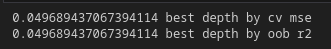\
получились одинаковые результаты (возможно влияние регуляризации через min_samples)

## task 4

По умолчанию mse? Сравним с mae

In [161]:
model1 = RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_leaf=2, criterion="absolute_error")
model2 = RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_leaf=2, criterion="squared_error")

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=50)

In [162]:
pred1 = model1.predict(X_train)
pred2 = model2.predict(X_train)

<Axes: >

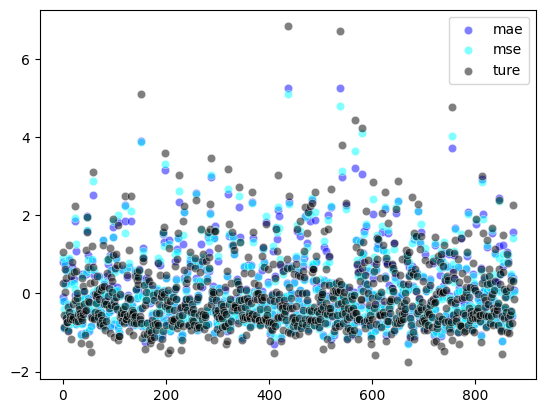

In [163]:
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred1, color='blue', label="mae", alpha=0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred2,  color='cyan', label="mse", alpha = 0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = y_train, color="black", label="ture", alpha = 0.5)

<Axes: >

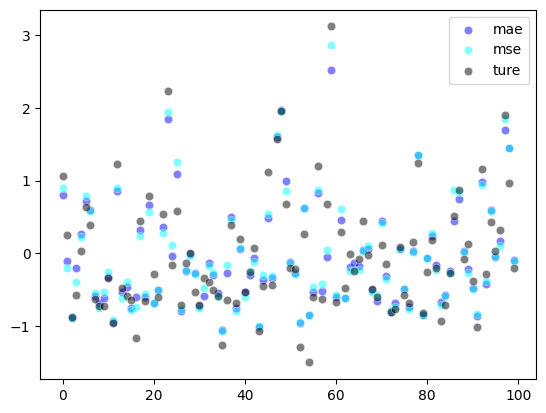

In [164]:
pred1 = pred1[:100]
pred2 = pred2[:100]
y = y_train[:100]

sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred1, color='blue', label="mae", alpha=0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred2,  color='cyan', label="mse", alpha = 0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = y, color="black", label="ture", alpha = 0.5)

Видим что mse мение чуствительна к выбросам, как и предполагалось.

## task 5

### шаги из 2 (3ий пункт предполагает их?)

In [185]:
from sklearn.ensemble import AdaBoostRegressor

par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
rf = RandomForestRegressor(n_estimators=1)
rcv = RandomizedSearchCV(rf, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
tree = RandomForestRegressor(n_estimators=1,**rcv.best_params_, bootstrap=False)
for i in range(20):
    ada = AdaBoostRegressor(tree, n_estimators=1, learning_rate=0.7)
    ada.fit(X_train,y_train)
    cv = cross_validate(ada,X_train,y_train,cv=10,scoring="r2")
    out_err.append(np.mean(cv["test_score"]))
    out_var.append(np.var(cv["test_score"]))

0.6739400021898775  сред r2 для набора из 1 estimatior RFregressor
0.013737568594815749  сред дисперсия


<Axes: >

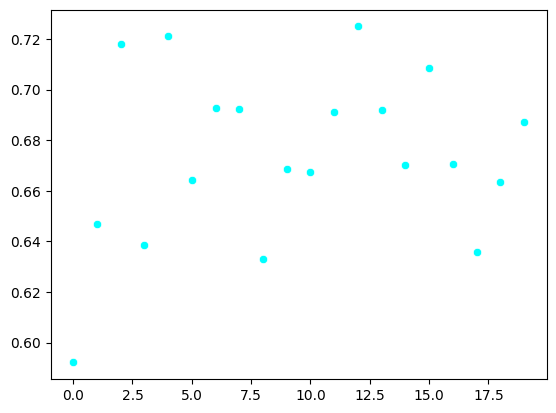

In [186]:
print(np.mean(out_err) , f" сред r2 для набора из 1 estimatior RFregressor")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

Точность от глубины:

In [167]:
for depth in range(5,10):
    tree = RandomForestRegressor(n_estimators=10,max_depth=depth, min_samples_leaf=2,random_state=2332)
    ada = AdaBoostRegressor(tree, n_estimators=10, learning_rate=0.7,random_state=1)
    cv = cross_validate(ada,X_train,y_train,cv=10,scoring="r2")
    print(f"depth {depth}")
    print(np.mean(cv["test_score"]), "mean score")
    print(np.var(cv["test_score"]), "var")

depth 5
0.8381793344542683 mean score
0.004012552423975304 var
depth 6
0.8443494255862779 mean score
0.003580949299027148 var
depth 7
0.8508374085774595 mean score
0.003784222166302975 var
depth 8
0.8477036080243883 mean score
0.004921757501576844 var
depth 9
0.8545352106211679 mean score
0.003652605427225513 var


In [168]:
meta = []
for i in range(10,100,10):
    model = RandomForestRegressor(n_estimators=i,max_depth=9,min_samples_leaf=2,random_state=1)
    ada = AdaBoostRegressor(model, n_estimators=10,random_state=1)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

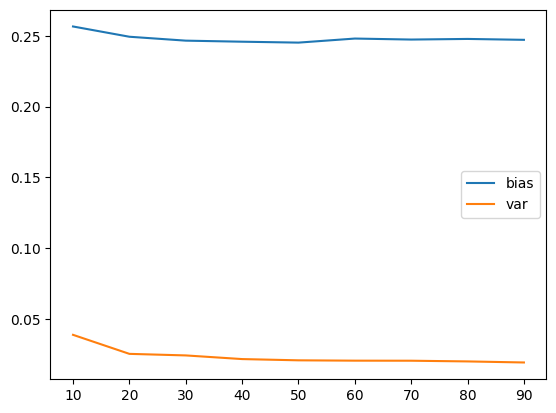

In [169]:
draw_bv(meta)

### шаги из 3

In [170]:
impot = []
tree = RandomForestRegressor(n_estimators=20, max_depth=6, min_samples_leaf=2)
ada = AdaBoostRegressor(tree,n_estimators=10,learning_rate=0.7, random_state=1)
ada.fit(X_train,y_train)
for num,feat in zip(ada.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(ada.predict(X_test), y_test), 'all features')

[(0.4908144205821659, 'OverallQual'), (0.10051226131051186, 'GrLivArea'), (0.0754423369033797, '2ndFlrSF'), (0.06185409323032942, 'GarageCars'), (0.028587364111939757, 'TotalBsmtSF'), (0.02425122794224719, 'BsmtFinSF1'), (0.024227600120001122, 'Neighborhood'), (0.022168998090438666, '1stFlrSF'), (0.018805188816012768, 'LotArea'), (0.013902468502572407, 'TotRmsAbvGrd'), (0.00993994088792926, 'YearRemodAdd'), (0.009512315051310411, 'LotFrontage'), (0.00949347642507296, 'YearBuilt'), (0.008712798430389655, 'Fireplaces'), (0.008593517701322785, 'GarageArea'), (0.008273594466663934, 'WoodDeckSF'), (0.007906689002905674, 'GarageYrBlt'), (0.00786999132088298, 'OpenPorchSF'), (0.007705905599623685, 'FullBath'), (0.007280507565149618, 'MoSold'), (0.005395511220287947, 'ScreenPorch'), (0.004581377050988861, 'MasVnrArea'), (0.0035080239173483556, 'KitchenQual'), (0.003281806879212525, 'BsmtUnfSF'), (0.0028446447372722328, 'OverallCond'), (0.0026038071864675975, 'ExterQual'), (0.002468830256803171

In [171]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    ada.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(ada.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'GrLivArea', '2ndFlrSF']
0.1562285954601434 on 3 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars']
0.14478610110460274 on 4 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF']
0.13767367738437752 on 5 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1']
0.12941477957920722 on 6 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1', 'Neighborhood']
0.13014874266489335 on 7 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1', 'Neighborhood', '1stFlrSF']
0.12724222468199398 on 8 features


Также хороший результат на меньшем наборе признаков

## task 6

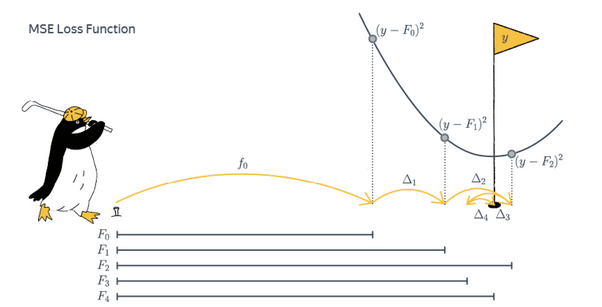

Основная идея заключается в том, что после обучения модели мы находим остатки через Loss функцию и затем обучаем след модель предсказывать ошибки прошлой.\
Формульно: мы строим комозицию из алгоритмов $a(x) = b_1(x) + b_2(x) + ... + b_n(x)$\
Если первый алгоритм обучается используя $\text{argmin}_b \, L(y_i,b(x_i))$ и теперь след алгоритм обучается на ошибках первого и улучшает предсказание.\
И если мы запишем обученеие i_ого алгоритма на ошибках и обобщим на дифф. функцию получим разложение в ряд тейлора:
\begin{equation}
L(y_i, a_k(x_i)) = L(y_i, a_{k-1}(x_i) + b(x_i)) = L(y_i, a_{k-1}(x_i)) + b(x_i)\frac{\delta L(y_i,a_{k-1}(x_i))}{\delta a_{k-1}(x_i)}
\end{equation},
где $a_{k-1}$ композиция на прошлом шаге, $b(x_i)$ ошибка композиции

Покажем на примере, который просто визуализировать

<Axes: xlabel='x', ylabel='y'>

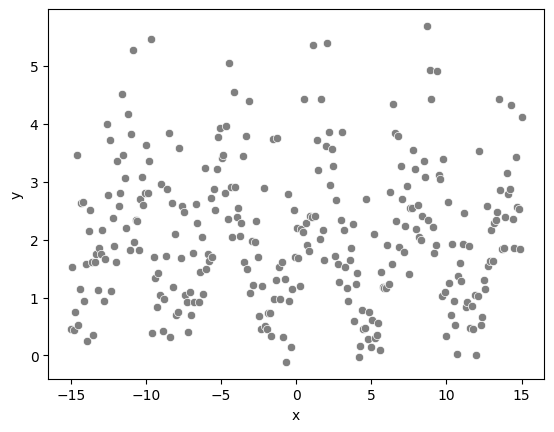

In [172]:
df = pd.DataFrame()
df["x"] = np.linspace(-15, 15, 300)
df["y"] = np.sin(df["x"]) + np.random.gamma(5,0.4,len(df['x']))
sns.scatterplot(x=df["x"], y=df["y"], color = "gray")

Обучим регрессор с 1ой итерацией

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1,max_depth=6, random_state=1)
x = pd.DataFrame(df['x'])
gbr.fit(x,df['y'])
pred = gbr.predict(x)

<Axes: xlabel='x', ylabel='y'>

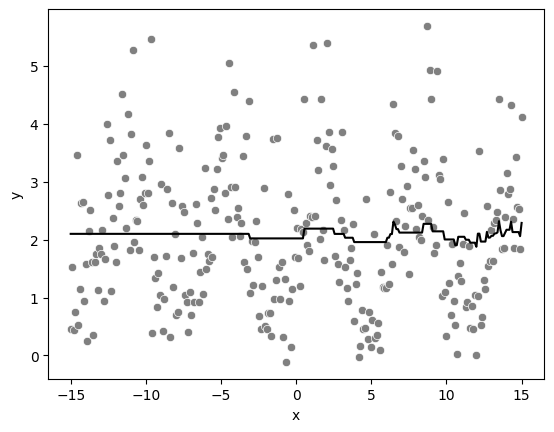

In [174]:
sns.scatterplot(x=df['x'], y=df["y"], color = "gray")
sns.lineplot(x=df['x'],y=pred, color = "black")

Теперь увеличим кол-во шагов обучения

In [175]:
gbr = GradientBoostingRegressor(n_estimators=2,max_depth=6, random_state=1)
x = pd.DataFrame(df['x'])
gbr.fit(x,df['y'])
pred = gbr.predict(x)

<Axes: xlabel='x', ylabel='y'>

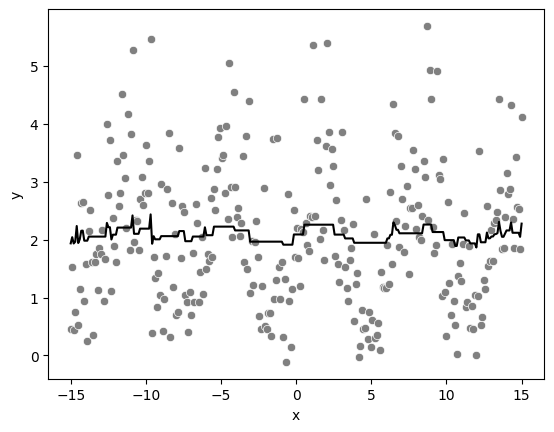

In [176]:
sns.scatterplot(x=df['x'], y=df["y"], color = "gray")
sns.lineplot(x=df['x'],y=pred, color = "black")

Видим что модель улучшает места где плохо отработала прошлая модель и так далее. Нужно быть осторожным т.к модель страдает от переобучения.

## task 7

In [177]:
from xgboost import XGBRegressor

### шаги из 2 (3ий пункт предполагает их?)

In [178]:
out_err = []
out_var = []

for i in range(20):
    model = XGBRegressor(n_estimators=1, learning_rate=0.1, max_depth = 6)
    model.fit(X_train,y_train)
    cv = cross_validate(model, X_train,y_train,cv=10, scoring="r2")
    out_err.append(np.mean(cv["test_score"]))
    out_var.append(np.var(cv["test_score"]))

0.1382441318996273  сред r2 набора по 1ому дереву
0.00022463610185302816  сред дисперсия


<Axes: >

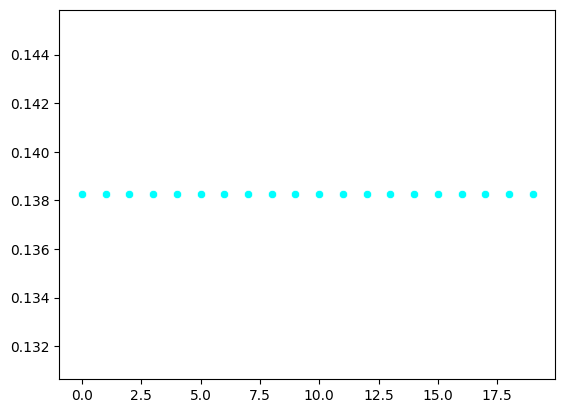

In [179]:
print(np.mean(out_err) , f" сред r2 набора по 1ому дереву")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

похоже XGboost в случае одного дерева строит самое оптимальное (нет сильной зависимости от random_state)

In [180]:
for depth in range(3,15):
    model = XGBRegressor(n_estimators=20, learning_rate=0.1, max_depth = depth , random_state = 99)
    cv = cross_validate(model,X_train,y_train,cv=10,scoring="r2")
    print(f"depth {depth}")
    print(np.mean(cv["test_score"]), "mean")
    print(np.var(cv["test_score"]), "var")

depth 3
0.7991085967684085 mean
0.0033405961594772707 var
depth 4
0.8179930960712187 mean
0.0033940303341244947 var
depth 5
0.8198262503206604 mean
0.003261811994838459 var
depth 6
0.8180174870770258 mean
0.0042158324312337805 var
depth 7
0.8089384395371237 mean
0.00491475976381221 var
depth 8
0.8094713504370692 mean
0.004203562353079217 var
depth 9
0.8100705440473689 mean
0.00426590824043027 var
depth 10
0.8112119404069628 mean
0.004360306762130134 var
depth 11
0.8084337008657521 mean
0.004339062293162288 var
depth 12
0.808680509777721 mean
0.004327911600255174 var
depth 13
0.8083195578477277 mean
0.004219870866664033 var
depth 14
0.8071661694411617 mean
0.004201084094323083 var


In [181]:
meta = []
for i in range(10,100,10):
    model = XGBRegressor(n_estimators=i, learning_rate = 0.1, max_depth=5)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11)
    meta.append((i, bias, var))

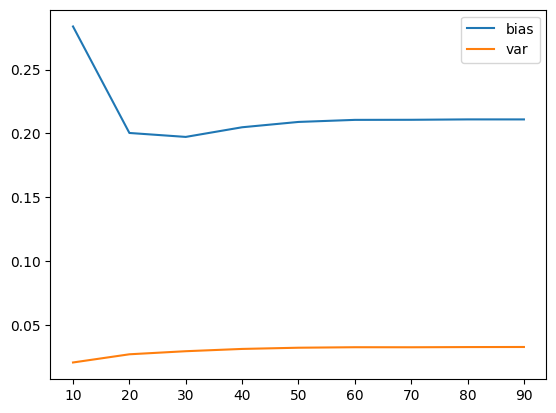

In [182]:
draw_bv(meta)

### шаги из 3

In [183]:
impot = []
model = XGBRegressor(n_estimators=20,learning_rate = 0.1, max_depth=5)
model.fit(X_train,y_train)
for num,feat in zip(model.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(model.predict(X_test), y_test), 'all features')

[(0.38961634, 'OverallQual'), (0.076495506, 'FullBath'), (0.06395513, 'GarageCars'), (0.033254895, 'Neighborhood'), (0.030556738, 'GrLivArea'), (0.02771137, '1stFlrSF'), (0.026607309, 'GarageFinish'), (0.026527522, '2ndFlrSF'), (0.020640079, 'GarageType'), (0.020330751, 'KitchenAbvGr'), (0.019727139, 'TotalBsmtSF'), (0.015747877, 'BsmtQual'), (0.015474187, 'KitchenQual'), (0.0146437185, 'GarageArea'), (0.013902131, 'Fireplaces'), (0.013759221, 'TotRmsAbvGrd'), (0.013704853, 'WoodDeckSF'), (0.010136683, 'HalfBath'), (0.010038334, 'YearRemodAdd'), (0.009218438, 'BsmtFinSF1'), (0.0091871135, 'YearBuilt'), (0.0089341495, 'LandContour'), (0.008379367, 'MSZoning'), (0.008219336, 'MasVnrArea'), (0.007880527, 'HeatingQC'), (0.0076543647, 'Exterior2nd'), (0.0071151354, 'HouseStyle'), (0.007016268, 'LotFrontage'), (0.00648708, 'ExterQual'), (0.0063888216, 'CentralAir'), (0.006148628, 'LandSlope'), (0.005972443, 'LotArea'), (0.0058454326, 'OverallCond'), (0.005764699, 'BsmtFullBath'), (0.00536405

In [184]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    model.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(model.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'FullBath', 'GarageCars']
0.2252713855790656 on 3 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood']
0.21286966016106226 on 4 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea']
0.17356908080270922 on 5 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF']
0.16559242948251973 on 6 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF', 'GarageFinish']
0.16329243839398497 on 7 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF', 'GarageFinish', '2ndFlrSF']
0.16594336981832772 on 8 features


Видим не такой значительный прирост как в примере 3. Видимо XGBoost хитро выбирает признаки.

no oob ;(